## Netflix Movie Recommendation

In [1]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# sns.set_style("darkgrid")

from surprise import Reader, Dataset, SVD # pip install scikit-surprise
from surprise.model_selection import cross_validate

## Load Data and Data Preprocessing

In [2]:
# q = pd.read_csv('qualifying.txt')

movies = pd.read_csv('movie_titles.csv', header = None, usecols = [0,1,2], names = ['MovieID', 'YearOfRelease', 'Title'],encoding='latin1')

In [3]:
movies.head()

df1 = pd.read_csv('combined_data_1.txt', names = ['Cust_Id', 'Rating'], usecols = [0,1])
# df2 = pd.read_csv('combined_data_2.txt', names = ['Cust_Id', 'Rating'], usecols = [0,1])
# df3 = pd.read_csv('combined_data_3.txt', names = ['Cust_Id', 'Rating'], usecols = [0,1])
# df4 = pd.read_csv('combined_data_4.txt', names = ['Cust_Id', 'Rating'], usecols = [0,1])
# df = pd.concat([df1, df2, df3, df4], axis = 0)
df = df1
df.shape

(24058263, 2)

In [4]:
df.isnull().sum()

Cust_Id       0
Rating     4499
dtype: int64

In [5]:
# Extract Movie ID:
nan = pd.DataFrame(pd.isnull(df['Rating']))
movie_id = df[nan['Rating'] == True]['Cust_Id']

movie_id.head(1000)

0             1:
548           2:
694           3:
2707          4:
2850          5:
           ...  
4996672     996:
5008531     997:
5008834     998:
5009281     999:
5010438    1000:
Name: Cust_Id, Length: 1000, dtype: object

In [6]:
# Take the ratings for the first 100 movies as our dataset
# df_100 = df.iloc[:352871,]
df_100 = df.iloc[:5010438] # 1000

print(df_100.shape)
print(movie_id.shape)
# m_id = movie_id.iloc[:101,] 
m_id = movie_id.iloc[:1000,] # 1000
m_id

(5010438, 2)
(4499,)


0             1:
548           2:
694           3:
2707          4:
2850          5:
           ...  
4996672     996:
5008531     997:
5008834     998:
5009281     999:
5010438    1000:
Name: Cust_Id, Length: 1000, dtype: object

In [7]:
# Use the index of the movies to generate Movie IDs corresponding to the rows (cutomer IDs)
Movie_ID = []
# for i in range(1,101):
for i in range(1,1000):
    Movie_ID.append((m_id.index[i]-m_id.index[i-1])*[i])
    
MovieID = sum(Movie_ID, [])

# Verify that they are the same length
print(len(MovieID),df_100.shape[0])

# Assign the Movie IDs to the rows
df_100['MovieID'] = MovieID

5010438 5010438


/home/celeste/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [8]:
# df_100.head()

In [9]:
# Delete the rows with the original Movie IDs
df_100_noNA = df_100.dropna()

print(df_100_noNA.isnull().sum())

print(df_100_noNA.shape)

display(df_100_noNA.head())

Cust_Id    0
Rating     0
MovieID    0
dtype: int64
(5009439, 3)


Cust_Id  Rating  MovieID
1  1488844     3.0        1
2   822109     5.0        1
3   885013     4.0        1
4    30878     4.0        1
5   823519     3.0        1

# Data Visualization

In [10]:
groupby = df_100_noNA.groupby(['Rating']).agg('count')
groupby

Cust_Id  MovieID
Rating                  
1.0      220809   220809
2.0      489048   489048
3.0     1431558  1431558
4.0     1733549  1733549
5.0     1134475  1134475

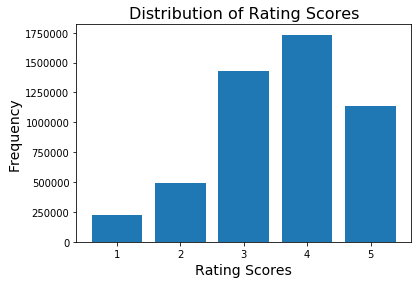

In [11]:
# Distribution of Rating Scores
plt.bar(groupby.index, groupby.MovieID)
plt.xlabel('Rating Scores', size=14)
plt.ylabel('Frequency', size=14)
plt.title('Distribution of Rating Scores', size=16)
plt.show()

In [12]:
df_100_noNA.groupby(['MovieID'])['Rating'].agg(['count','mean'])

count      mean
MovieID                 
1          547  3.749543
2          145  3.558621
3         2012  3.641153
4          142  2.739437
5         1140  3.919298
...        ...       ...
995        104  1.721154
996      11858  4.031540
997        302  3.251656
998        446  3.316143
999       1156  2.727509

[999 rows x 2 columns]

## Movies:

In [13]:
# Minimum number of ratings on a movie is 78
df_100_noNA.groupby(['MovieID']).agg('count').agg([np.min])

Cust_Id  Rating
amin       43      43

In [14]:
# Maximum number of ratings on a movie is 118,413
df_100_noNA.groupby(['MovieID']).agg('count').agg([np.max])

Cust_Id  Rating
amax   154832  154832

In [15]:
# Average number of ratings on a movie is 3,527
df_100_noNA.groupby(['MovieID']).agg('count').agg([np.mean])

Cust_Id       Rating
mean  5014.453453  5014.453453

## Customers:

In [16]:
# Minimum number of ratings by customer is 1
df_100_noNA.groupby(['Cust_Id']).agg('count').agg([np.min])

Rating  MovieID
amin       1        1

In [17]:
# Maximum number of ratings by custormer is 97
df_100_noNA.groupby(['Cust_Id']).agg('count').agg([np.max])

Rating  MovieID
amax     992      992

In [18]:
# Average number of ratings per customer is 1.84
df_100_noNA.groupby(['Cust_Id']).agg('count').agg([np.mean])

Rating    MovieID
mean  12.382866  12.382866

In [19]:
# Count of Ratings and the average rating scores for each movie:
count_rating = df_100_noNA.groupby(['MovieID'])['Rating'].agg(['count','mean'])

In [20]:
count_rating

count      mean
MovieID                 
1          547  3.749543
2          145  3.558621
3         2012  3.641153
4          142  2.739437
5         1140  3.919298
...        ...       ...
995        104  1.721154
996      11858  4.031540
997        302  3.251656
998        446  3.316143
999       1156  2.727509

[999 rows x 2 columns]

In [21]:
np.mean(df[:1000].Rating)
np.std(df[:1000].Rating)

1.0928491049199107

In [22]:
np.mean(count_rating['count'])

5014.453453453453

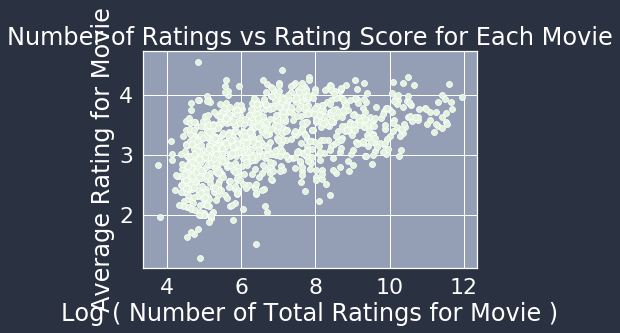

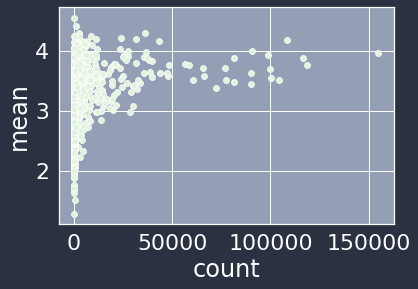

In [23]:
# plt.style.use("seaborn")
# plt.figure(figsize=(14,10))
# plt.scatter(np.log(count_rating['count']), count_rating['mean'])
sns.set(rc={'text.color':"white", 
            'axes.labelcolor': 'white', 
            'xtick.color': 'white', 
            'ytick.color': 'white', 
            'axes.facecolor': '#949fb5',
            'figure.facecolor': '#2a3242'}, 
        font_scale=2, palette='Greens')
sns.scatterplot(np.log(count_rating['count']), count_rating['mean'])
# sns.scatterplot(count_rating['count'], count_rating['mean'])
plt.xlabel('Log ( Number of Total Ratings for Movie )')
plt.ylabel('Average Rating for Movie')
plt.title('Number of Ratings vs Rating Score for Each Movie')
plt.show()
sns.scatterplot(count_rating['count'], count_rating['mean'])

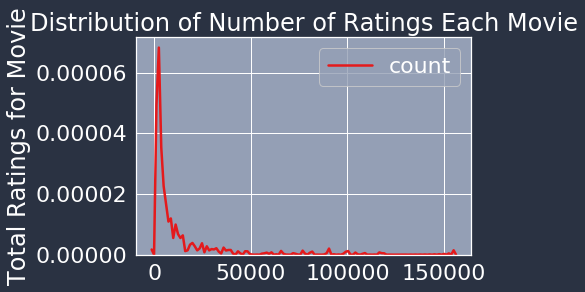

In [24]:
# plt.figure(figsize=(15,12))
sns.set(rc={'text.color':"white", 
            'axes.labelcolor': 'white', 
            'xtick.color': 'white', 
            'ytick.color': 'white', 
            'axes.facecolor': '#949fb5',
            'figure.facecolor': '#2a3242',
            'lines.linewidth': 2.5}, 
        font_scale=2, palette='Set1')
sns.kdeplot(count_rating['count'])
plt.ylabel('Total Ratings for Movie')
plt.title('Distribution of Number of Ratings Each Movie')
plt.show()

In [25]:
# Bad movies (with a low rating score) tend to have less ratings
# movies with an average rating score of less than 2.5 , never had more than e^7 ratings.
# good movies (with a high rating score) can have very low number of ratings

### Data set viz

In [26]:
import seaborn as sns

df_100_noNA.head()

Cust_Id  Rating  MovieID
1  1488844     3.0        1
2   822109     5.0        1
3   885013     4.0        1
4    30878     4.0        1
5   823519     3.0        1

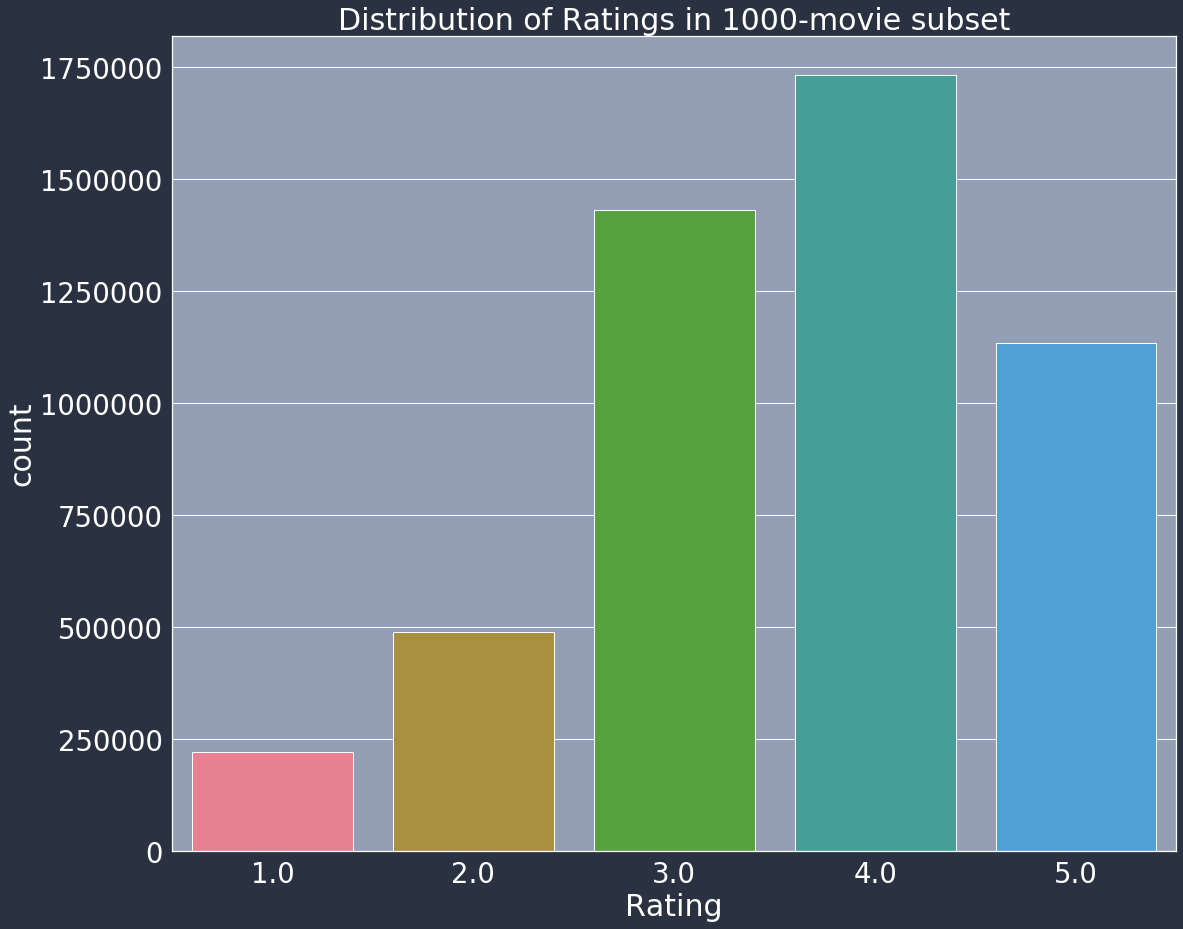

In [27]:
import seaborn
plt.figure(figsize=(18,15))
sns.set(rc={'text.color':"white", 
            'axes.labelcolor': 'white', 
            'xtick.color': 'white', 
            'ytick.color': 'white', 
            'axes.facecolor': '#949fb5',
            'figure.facecolor': '#2a3242'}, 
        font_scale=2.5, palette='husl')
sns.countplot(df_100_noNA.Rating)
_ = plt.title("Distribution of Ratings in 1000-movie subset")

## SVD Model Fitting

In [28]:
df_100_noNA.shape

(5009439, 3)

Pivot causes memory overload and dead kernel

In [29]:
# # Pivot the data into a matrix with Customer ID as the row labels, Movie ID as the column labels, and ratings as values
# df_pivot = pd.pivot_table(df_100_noNA,values='Rating',index='Cust_Id',columns='MovieID')

# movies.set_index('MovieID', inplace = True)

# df_100_noNA_org = df_100_noNA

# df_100_noNA = df_100_noNA.astype('int32')

In [30]:
# reader = Reader()
# data = Dataset.load_from_df(df_100_noNA[['Cust_Id', 'MovieID', 'Rating']], reader)

# # Fitting the model with 3-fold cross validation
# svd = SVD()
# cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

### KNN Model with surprise

In [31]:
# print(data.df.dtypes)
# data.df = data.df.astype('int32')

In [32]:
# mod_raw_ratings = [[x[0], x[1], int(x[2]), x[3]] for x in data.raw_ratings]
# df.raw_ratings = mod_raw_ratings
# del mod_raw_ratings

In [33]:
# from surprise import KNNBasic

In [34]:
# bsl_options = {'method': 'als', 'n_epochs': 2}
# sim_options = {'name': 'cosine'} # Similarity metric for neighbors 

In [35]:
# knn_model_surprise = KNNBasic(k=5, bsl_options=bsl_options, sim_options=sim_options)
# cross_validate(knn_model_surprise, data, measures=['RMSE', 'MAE'])

# KNN Model with sklearn & manual 

Using same pivoted data converted into sparse matrix

In [36]:
from scipy.sparse import csr_matrix # pivot ratings into movie features
from sklearn.metrics.pairwise import cosine_similarity

In [37]:
df_100_noNA.Rating = df_100_noNA.Rating.astype('int32')
df_100_noNA.Cust_Id = df_100_noNA.Cust_Id.astype('int32')
df_100_noNA.reset_index(inplace=True, drop=True)

/home/celeste/.local/lib/python3.6/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [38]:
fourth = 125235
df_movie_features = df_100_noNA[:fourth].pivot(
                index='MovieID',
                columns='Cust_Id',
                values='Rating').fillna(0)

In [ ]:
# convert dataframe of movie features to scipy sparse matrix
# mat_movie_features = csr_matrix(df_movie_features.values)

In [ ]:
# Too big for now
# df_movie_features = df_100_noNA.pivot(
#     index='MovieID',
#     columns='Cust_Id',
#     values='Rating'
# ).fillna(0)

In [39]:
# Replace movie ID with movie name
# Too big for now
# TODO at end 
df_movie_features.index = df_movie_features.index.map(movies.Title)

In [40]:
# Free up some memory for the cosine similarity computation 
# del mat_movie_features
del df_100
del movie_id
del df
del movies
del df_100_noNA

#### The  algorithm  consists  of  three  basic  steps:  [1]
1. user  similarity  calculation (cosine similarities on user rows :) )
2. nearest neighbor selection and 
3. prediction score calculation

After the calculation of similarity as cosine similarity between users, then  the  algorithm  selects  a  number  of  users  the  highest  similarity as the U’s neighbor, denoted as u'.

After  determining  the  user's K nearest neighbors,  the  score  can  be  predicted according to the score of the neighbor to the item, The calculation formula is as follows:



In [48]:
df_fts2 = df_fts[:12523]

In [50]:
df_fts = df_movie_features.transpose() # Try with user rows instead so we can compare user similarity 

NameError: name 'df_movie_features' is not defined

In [42]:
del df_movie_features

In [43]:
print(df_fts.shape)
df_fts.head()

(98986, 30)


MovieID  Isle of Man TT 2004 Review  Character  Paula Abdul's Get Up & Dance  \
Cust_Id                                                                        
7                               0.0        0.0                           0.0   
42                              0.0        0.0                           0.0   
59                              0.0        0.0                           0.0   
134                             0.0        0.0                           0.0   
199                             0.0        0.0                           0.0   

MovieID  The Rise and Fall of ECW  Sick  8 Man  What the #$*! Do We Know!?  \
Cust_Id                                                                      
7                             0.0   0.0    0.0                         0.0   
42                            0.0   0.0    0.0                         0.0   
59                            0.0   0.0    0.0                         0.0   
134                           0.0   0.0    0.0                         0.0   
199                           0.0   0.0    0.0                         0.0   

MovieID  Class of Nuke 'Em High 2  Fighter  Full Frame: Documentary Shorts  \
Cust_Id                                                                      
7                             5.0      0.0                             0.0   
42                            0.0      0.0                             0.0   
59                            0.0      0.0                             0.0   
134                           0.0      0.0                             0.0   
199                           0.0      0.0                             0.0   

MovieID  ...  Chump Change  \
Cust_Id  ...                 
7        ...           0.0   
42       ...           0.0   
59       ...           0.0   
134      ...           0.0   
199      ...           0.0   

MovieID  Clifford: Clifford Saves the Day! / Clifford's Fluffiest Friend Cleo  \
Cust_Id                                                                         
7                                                      0.0                      
42                                                     0.0                      
59                                                     0.0                      
134                                                    0.0                      
199                                                    0.0                      

MovieID  My Bloody Valentine  Inspector Morse 31: Death Is Now My Neighbour  \
Cust_Id                                                                       
7                        0.0                                            0.0   
42                       0.0                                            0.0   
59                       0.0                                            0.0   
134                      0.0                                            0.0   
199                      0.0                                            0.0   

MovieID  Never Die Alone  Sesame Street: Elmo's World: The Street We Live On  \
Cust_Id                                                                        
7                    0.0                                                0.0    
42                   0.0                                                0.0    
59                   0.0                                                0.0    
134                  0.0                                                0.0    
199                  0.0                                                0.0    

MovieID  Lilo and Stitch  Boycott  Something's Gotta Give  \
Cust_Id                                                     
7                    0.0      4.0                     0.0   
42                   0.0      0.0                     0.0   
59                   0.0      0.0                     0.0   
134                  0.0      5.0                     0.0   
199                  0.0      0.0                     0.0   

MovieID  Classic Albums

Cosine similarity 

https://stackoverflow.com/questions/17627219/whats-the-fastest-way-in-python-to-calculate-cosine-similarity-given-sparse-mat/39104306#39104306

In [44]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

In [51]:
df_sparse = sparse.csr_matrix(df_fts2.transpose())
# df_sparse = sparse.csr_matrix(df_fts.transpose())

In [52]:
df_sparse.shape

(30, 12523)

In [53]:
def cosine_similarity_csr(matrix):
    norm = pd.DataFrame(np.sqrt(np.square(matrix).sum(axis = 1)))
    denominator = norm.dot(norm.T)
    numerator = matrix.dot(matrix.T)
    similarity_matrix = numerator.divide(denominator,axis =0)
    return similarity_matrix
# Similarity between customers 
customer_similarity = cosine_similarity_csr(df_fts[:10])
# customer_similarity = cosine_similarity_csr(df_sparse)
customer_similarity

Cust_Id       7    42   59        134  199       201  261       265       307  \
Cust_Id                                                                         
7        1.000000  0.0  0.0  0.624695  0.0  0.624695  0.0  0.624695  0.780869   
42       0.000000  1.0  1.0  0.000000  1.0  0.000000  1.0  0.000000  0.000000   
59       0.000000  1.0  1.0  0.000000  1.0  0.000000  1.0  0.000000  0.000000   
134      0.624695  0.0  0.0  1.000000  0.0  1.000000  0.0  1.000000  0.000000   
199      0.000000  1.0  1.0  0.000000  1.0  0.000000  1.0  0.000000  0.000000   
201      0.624695  0.0  0.0  1.000000  0.0  1.000000  0.0  1.000000  0.000000   
261      0.000000  1.0  1.0  0.000000  1.0  0.000000  1.0  0.000000  0.000000   
265      0.624695  0.0  0.0  1.000000  0.0  1.000000  0.0  1.000000  0.000000   
307      0.780869  0.0  0.0  0.000000  0.0  0.000000  0.0  0.000000  1.000000   
383      0.624695  0.0  0.0  1.000000  0.0  1.000000  0.0  1.000000  0.000000   

Cust_Id       383  
Cust_Id            
7        0.624695  
42       0.000000  
59       0.000000  
134      1.000000  
199      0.000000  
201      1.000000  
261      0.000000  
265      1.000000  
307      0.000000  
383      1.000000

In [ ]:
# print(df_fts.shape)
# df_fts_subset = df_fts[df_fts.columns[:50]].astype('int32')
# A_sparse = sparse.csr_matrix(df_fts_subset)
# similarities = cosine_similarity(A_sparse)

Need to convert to sparse matrix and preprocess or else not enough RAM

In [54]:
import sklearn.preprocessing as pp
def cosine_similarities(mat):
    col_normed_mat = pp.normalize(mat.tocsc(), axis=0)  # scipy.sparse.csc_matrix
    return col_normed_mat.T * col_normed_mat

customer_similarities = cosine_similarities(df_sparse)

In [55]:
print(customer_similarities.toarray().shape)
customer_similarities= customer_similarities.toarray()

(12523, 12523)


In [56]:
user_similarity_matrix = pd.DataFrame(customer_similarities)
# cs_df.columns = df_fts.index.values  # Customer IDs 12523
user_similarity_matrix.columns = df_fts[:12523].index.values  # Customer IDs 
user_similarity_matrix
# set the column and index to customer ID
# Get the top K customer scores for each row 
# Rank function
user_similarity_matrix.index = user_similarity_matrix.columns

In [64]:
user_similarity_matrix

7         42        59        134       199       201       261     \
7       1.000000  0.000000  0.000000  0.624695  0.000000  0.624695  0.000000   
42      0.000000  1.000000  1.000000  0.000000  1.000000  0.000000  1.000000   
59      0.000000  1.000000  1.000000  0.000000  1.000000  0.000000  1.000000   
134     0.624695  0.000000  0.000000  1.000000  0.000000  1.000000  0.000000   
199     0.000000  1.000000  1.000000  0.000000  1.000000  0.000000  1.000000   
...          ...       ...       ...       ...       ...       ...       ...   
336842  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
336847  0.487805  0.000000  0.000000  0.780869  0.000000  0.780869  0.000000   
336882  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
336895  0.624695  0.000000  0.000000  1.000000  0.000000  1.000000  0.000000   
336940  0.441726  0.707107  0.707107  0.707107  0.707107  0.707107  0.707107   

          265       307       383     ...    336784    336789    336807  \
7       0.624695  0.780869  0.624695  ...  0.624695  0.374817  0.624695   
42      0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
59      0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
134     1.000000  0.000000  1.000000  ...  1.000000  0.600000  1.000000   
199     0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
...          ...       ...       ...  ...       ...       ...       ...   
336842  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
336847  0.780869  0.000000  0.780869  ...  0.780869  0.468521  0.780869   
336882  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
336895  1.000000  0.000000  1.000000  ...  1.000000  0.600000  1.000000   
336940  0.707107  0.000000  0.707107  ...  0.707107  0.424264  0.707107   

          336821  336829  336842    336847  336882    336895    336940  
7       0.000000     0.0     0.0  0.487805     0.0  0.624695  0.441726  
42      1.000000     0.0     0.0  0.000000     0.0  0.000000  0.707107  
59      1.000000     0.0     0.0  0.000000     0.0  0.000000  0.707107  
134     0.000000     0.0     0.0  0.780869     0.0  1.000000  0.707107  
199     1.000000     0.0     0.0  0.000000     0.0  0.000000  0.707107  
...          ...     ...     ...       ...     ...       ...       ...  
336842  0.000000     0.0     1.0  0.000000     0.0  0.000000  0.000000  
336847  0.000000     0.0     0.0  1.000000     0.0  0.780869  0.552158  
336882  0.000000     0.0     0.0  0.000000     1.0  0.000000  0.000000  
336895  0.000000     0.0     0.0  0.780869     0.0  1.000000  0.707107  
336940  0.707107     0.0     0.0  0.552158     0.0  0.707107  1.000000  

[12523 rows x 12523 columns]

In [58]:
# Free up memory
del customer_similarities

In [59]:
K=20
# np.sort(cs)[:,-K:] # NEed to preserve index (customer)

# Predict Score Calculation
### Implement custom ranking function

KNN nearest neighbor selection After the calculation of similarity between users, then  the  algorithm  selects  a  number  of  users  the  highest  similarity as the U’s neighbor, denoted as u'. set a fixed value K  for  the  neighbor  selection,  select  only  the  most  K  high  similarity as neighbors regardless of the value of the neighbor similarity of users. As shown in figure 4. Fig.4. formula of K nearest neighbors when k=7 3.3Predict score calculation After  determining  the  user's  neighbors,  the  score  can  be  predicted according to the score of the neighbor to the item

<img src="files/ranking_function.png">

The above equation is used to get the ranking r for user u on movie i. 
It states that the ranking r for user u on movie i is equal to the average ranking from the user u (?) plus the SUM from other users in the top similar users of the similarity of those two users (proportionality) times the ranking user u' gave movie i - the average ranking user u' gave to its movies. 

In [ ]:
# customer_similarity_row = customer_similarity.loc[6]
# user_similarity_matrix

In [ ]:
# knn for u 
# uprime = 

In [62]:
movie_id = "Lilo and Stitch"
user_id = 7
df = df_fts2
user_row = user_similarity_matrix.loc[user_id]  # Customer user_id's similarities to all other customers 

In [63]:
# Free up space
del df_fts
del df_fts2
del df_sparse

Using df and user_similarity matrix, we can do the calculation above

In [64]:
with pd.option_context('display.max_columns', None):
    display(df.head())

MovieID  Isle of Man TT 2004 Review  Character  Paula Abdul's Get Up & Dance  \
Cust_Id                                                                        
7                               0.0        0.0                           0.0   
42                              0.0        0.0                           0.0   
59                              0.0        0.0                           0.0   
134                             0.0        0.0                           0.0   
199                             0.0        0.0                           0.0   

MovieID  The Rise and Fall of ECW  Sick  8 Man  What the #$*! Do We Know!?  \
Cust_Id                                                                      
7                             0.0   0.0    0.0                         0.0   
42                            0.0   0.0    0.0                         0.0   
59                            0.0   0.0    0.0                         0.0   
134                           0.0   0.0    0.0                         0.0   
199                           0.0   0.0    0.0                         0.0   

MovieID  Class of Nuke 'Em High 2  Fighter  Full Frame: Documentary Shorts  \
Cust_Id                                                                      
7                             5.0      0.0                             0.0   
42                            0.0      0.0                             0.0   
59                            0.0      0.0                             0.0   
134                           0.0      0.0                             0.0   
199                           0.0      0.0                             0.0   

MovieID  My Favorite Brunette  \
Cust_Id                         
7                         0.0   
42                        0.0   
59                        0.0   
134                       0.0   
199                       0.0   

MovieID  Lord of the Rings: The Return of the King: Extended Edition: Bonus Material  \
Cust_Id                                                                                
7                                                      0.0                             
42                                                     0.0                             
59                                                     0.0                             
134                                                    0.0                             
199                                                    0.0                             

MovieID  Nature: Antarctica  Neil Diamond: Greatest Hits Live  Screamers  \
Cust_Id                                                                    
7                       0.0                               0.0        0.0   
42                      0.0                               0.0        0.0   
59                      0.0                               0.0        0.0   
134                     0.0                               0.0        0.0   
199                     0.0                               0.0        0.0   

MovieID  7 Seconds  Immortal Beloved  By Dawn's Early Light  Seeta Aur Geeta  \
Cust_Id                                                                        
7              0.0               0.0                    0.0              0.0   
42             0.0               0.0                    0.0              0.0   
59             0.0               0.0                    0.0              0.0   
134            0.0               0.0                    0.0              0.0   
199            0.0               0.0                    0.0              0.0   

MovieID  Strange Relations  Chump Change  \
Cust_Id                                    
7                      0.0           0.0   
42                     0.0           0.0   
59                     0.0           0.0   
134                    0.0           0.0   
199                    0.0           0.0   

MovieID  Clifford: Clifford Saves the Day! / Clifford's Fluffiest Friend Cleo  \
Cust_Id     

In [66]:
def rank_user_movie(user_row, movie_id, df):
    user_similarities_top_k = user_row.nlargest(K)  # Most similar customers to customer in user_row 
    nearest_neighbors_cust_ID = user_similarities_top_k.index.values

    r_u = df.loc[user_id]  #  ranking from the user u - user user_id's row from df across all movies
    r_u_bar = np.mean(r_u.where(r_u>0)) # average nonzero rankings in all user's rankings, r_u

    k = 1/np.sum(user_similarities_top_k)
    # For each most nearest user u', zum the similarity between that user and our user u, times the 
    # rank for nearest user u' for that specific movie - the average ranking for all movies for nearest user u'
    sum3=[]
    for u_prime, sim_u_uprime in zip(nearest_neighbors_cust_ID, user_similarities_top_k):
        r_u_prime_i=df.loc[u_prime][movie_id]
        r_u_prime = df.loc[u_prime]
        r_u_prime_bar= np.mean(r_u_prime.where(r_u_prime>0))
        sum3.append(sim_u_uprime*(r_u_prime_i - r_u_prime_bar))

    r_u_i = r_u_bar + k*np.sum(sum3)

    return r_u_i 

rank_user_movie(user_row=user_row, movie_id="Lilo and Stitch",df=df)

0.24990850310544754

In [ ]:
# # Get K nearest neighbors for each use 
# # r_u,i is each score. rank from user u for movie i 
# # sim(u, u') is the similarity between any two users u and ui (the u, u'th entry in user_similarity_matrix)
# def get_nearest_neighbors(customer_similarity_row, K=7):
#     return customer_similarity_row.nlargest(K)
# K = 7
# neighbors = customer_similarity.apply(get_nearest_neighbors)

Now our training data has a very high dimensionality. KNN’s performance will suffer from curse of dimensionality if it uses “euclidean distance” in its objective function. Euclidean distance is unhelpful in high dimensions because all vectors are almost equidistant to the search query vector (target movie’s features).

Instead, we will use cosine similarity for nearest neighbor search. There is also another popular approach to handle nearest neighbor search in high dimensional data, locality sensitive hashing.

In [ ]:
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

Put it all together

In [ ]:
model_knn.fit(df_movie_features)

In [ ]:
np.count_nonzero(df_movie_features) # Number of ratings

In [ ]:
# inference
print('Recommendation system start to make inference')
n_recommendations = 10
movie_i_like = 'Rudolph the Red-Nosed Reindeer'
movie_data_point = np.array(df_movie_features.loc[movie_i_like]).reshape(1,-1)
distances, indices = model_knn.kneighbors(movie_data_point, n_neighbors=n_recommendations+1)

In [ ]:
# To compare to SVD, the output should be a rating score for each user-movie pair
# Output movie ratings for all movies for a single user
print(distances)
print(indices)

In [ ]:
# get list of raw idx of recommendations
raw_recommends = \
    sorted(
        list(
            zip(
                indices.squeeze().tolist(),
                distances.squeeze().tolist()
            )
        ),
        key=lambda x: x[1]
    )[:0:-1]

# show recommendation (movieId, distance)
raw_recommends
recommends_idcs = [x[0] for x in raw_recommends]
df_movie_features.iloc[recommends_idcs].index.values

References

[1] https://www.itm-conferences.org/articles/itmconf/pdf/2017/04/itmconf_ita2017_04008.pdf

